**📘 CNN Smile Classifier — From Baseline to Bias Analysis and Fine-Tuning**

## 1. Project Overview

This notebook presents the development and evaluation of a Convolutional Neural Network (CNN) for binary facial expression classification (smiling vs. not smiling).

The project follows a structured experimental pipeline:
1. Build a simple baseline CNN
2. Train and evaluate it on the CelebA dataset
3. Analyze potential bias across demographic groups
4. Fine-tune the model on a smaller external dataset
5. Re-evaluate performance and bias after fine-tuning

The goal is not only to maximize accuracy, but also to understand **generalization, fairness, and ethical implications** of model adaptation.


## 2. Baseline CNN Architecture

We begin with a **simple and interpretable CNN architecture**.

Design choices:
- Small number of convolutional layers
- ReLU activation for non-linearity
- MaxPooling for spatial downsampling
- Sigmoid output for binary classification

This intentionally minimal architecture serves as a **transparent baseline** for later comparison.


In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [2]:
model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## 3. Dataset Description (CelebA)

The baseline model is trained using a subset of the CelebA dataset.

Key characteristics:
- High-resolution face images
- Binary attribute labels
- Includes demographic attributes (e.g., gender, skin tone proxy)

Target label:
- **Smiling** (converted from {-1, 1} to {0, 1})

CelebA enables not only performance evaluation, but also **bias analysis across demographic subgroups**.


In [7]:
import os
import cv2
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [8]:
data = pd.read_csv("metadata.csv")

print(data.head())
print(data["Smiling"].value_counts())

     image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  We

In [9]:
data["Smiling"] = (data["Smiling"] == 1).astype(int)


## 4. Data Preprocessing & Dataset Splitting

Steps applied:
- Image resizing to 64×64
- Pixel normalization to [0, 1]
- Stratified splitting to preserve class balance

Dataset split:
- Training set
- Validation set
- Test set

Stratification ensures that smiling/non-smiling labels remain balanced across all splits.


In [10]:
data_subset, _ = train_test_split(
    data,
    test_size=0.70,
    random_state=42,
    stratify=data["Smiling"]
)

print("Subset size:", len(data_subset))
train_data, temp_data = train_test_split(
    data_subset,
    test_size=0.3,
    random_state=42,
    stratify=data_subset["Smiling"]
)

val_data, test_data = train_test_split(
    temp_data,
    test_size=0.5,
    random_state=42,
    stratify=temp_data["Smiling"]
)

print(len(train_data), len(val_data), len(test_data))


Subset size: 60779
42545 9117 9117


In [11]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm 

def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    return img

In [12]:
def create_dataset_fast(df, image_dir, max_workers=8):
    image_paths = [os.path.join(image_dir, img_id) for img_id in df["image_id"].values]
    labels = df["Smiling"].values
    
    X = []
    y = []
    
    # Parallel loading with progress bar
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(
            executor.map(load_image, image_paths),
            total=len(image_paths),
            desc="Loading images"
        ))
    
    # Filter out failed loads
    for img, label in zip(results, labels):
        if img is not None:
            X.append(img)
            y.append(label)
    
    return np.array(X, dtype=np.float32), np.array(y)

In [13]:
IMAGE_DIR = "celeba/img_align_celeba"

X_train, y_train = create_dataset_fast(train_data, IMAGE_DIR)
X_val, y_val = create_dataset_fast(val_data, IMAGE_DIR)
X_test, y_test = create_dataset_fast(test_data, IMAGE_DIR)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Loading images: 100%|██████████| 9117/9117 [00:19<00:00, 473.52it/s]


Train: (42545, 64, 64, 3) (42545,)
Val: (9117, 64, 64, 3) (9117,)
Test: (9117, 64, 64, 3) (9117,)


## 5. Data Augmentation

To improve generalization, data augmentation is applied during training:

- Horizontal flipping
- Small rotations
- Zoom perturbations

These transformations simulate natural facial variations without altering the semantic label.


In [14]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1
)

val_test_datagen = ImageDataGenerator()


In [15]:
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_test_datagen.flow(
    X_val, y_val,
    batch_size=32,
    shuffle=False
)

test_generator = val_test_datagen.flow(
    X_test, y_test,
    batch_size=32,
    shuffle=False
)


## 6. Baseline Training Procedure

The baseline CNN is trained using:
- Optimizer: Stochastic Gradient Descent (SGD)
- Loss function: Binary Cross-Entropy
- Early stopping based on validation loss

SGD was selected for its **stability and interpretability**, making training dynamics easier to analyze.


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [15]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


In [16]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[early_stop]
)


Epoch 1/15
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 103s 76ms/step - accuracy: 0.6520 - loss: 0.6239 - val_accuracy: 0.7642 - val_loss: 0.4976
Epoch 2/15
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 103s 77ms/step - accuracy: 0.7980 - loss: 0.4414 - val_accuracy: 0.8648 - val_loss: 0.3217
Epoch 3/15
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 104s 78ms/step - accuracy: 0.8406 - loss: 0.3590 - val_accuracy: 0.8702 - val_loss: 0.3068
Epoch 4/15
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 99s 74ms/step - accuracy: 0.8578 - loss: 0.3306 - val_accuracy: 0.8872 - val_loss: 0.2704
Epoch 5/15
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 97s 73ms/step - accuracy: 0.8664 - loss: 0.3072 - val_accuracy: 0.8754 - val_loss: 0.2940
Epoch 6/15
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 105s 79ms/step - accuracy: 0.8797 - loss: 0.2884 - val_accuracy: 0.8997 - val_loss: 0.2526
Epoch 7/15
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 100s 75ms/step - accuracy: 0.8806 - loss: 0.2810 - val_accuracy: 0.8859 - val_loss: 0.2723
Epoch 8/15
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 111s 84ms/step - accuracy: 0.

## 7. Baseline Performance Evaluation

After training, the model is evaluated on the held-out test set.

Metrics reported:
- Test accuracy
- Test loss

The baseline model achieves strong performance, indicating that even a simple CNN can effectively learn facial expression features.


In [17]:
test_loss, test_accuracy = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9061 - loss: 0.2202
Test Loss: 0.22023078799247742
Test Accuracy: 0.9061094522476196


In [18]:
model.save("baseline_smile_cnn.h5")


## 8. Training Curves

Accuracy and loss curves are plotted for both training and validation sets.

These plots help identify:
- Overfitting
- Underfitting
- Training stability


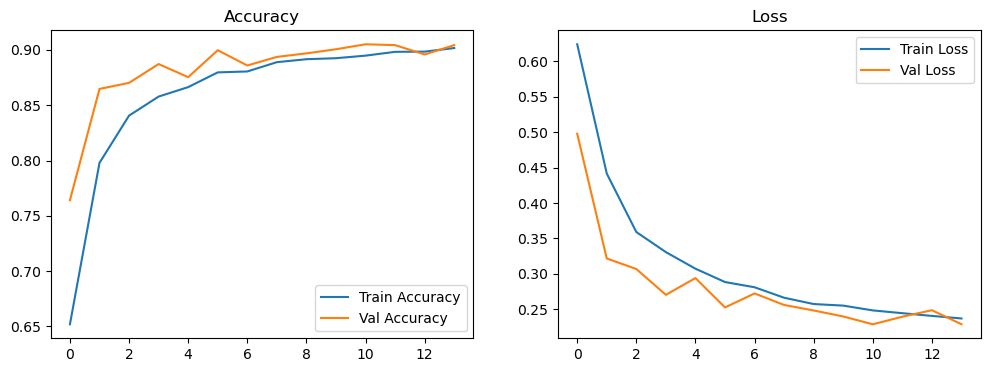

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()


## 9. Bias Evaluation Methodology

Beyond overall accuracy, we evaluate model behavior across demographic subgroups.

Groups analyzed:
- Gender (Male / Female)
- Skin tone proxy (Pale / Non-pale)

Metric:
- Group-wise accuracy
- Accuracy gap between groups

This analysis helps assess **fairness and performance consistency**.


In [20]:
from tensorflow.keras.models import load_model

model = load_model("baseline_smile_cnn.h5")


In [21]:
import numpy as np

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()


285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


In [22]:
test_eval = test_data.copy()
test_eval = test_eval.reset_index(drop=True)

test_eval["y_true"] = y_test
test_eval["y_pred"] = y_pred


In [23]:
def group_accuracy(df):
    return (df["y_true"] == df["y_pred"]).mean()


In [24]:
male_data = test_eval[test_eval["Male"] == 1]
female_data = test_eval[test_eval["Male"] == -1]

male_acc = group_accuracy(male_data)
female_acc = group_accuracy(female_data)

print("Accuracy (Male):", male_acc)
print("Accuracy (Female):", female_acc)
print("Gender Accuracy Gap:", abs(male_acc - female_acc))


Accuracy (Male): 0.8963350785340314
Accuracy (Female): 0.9131583915423824
Gender Accuracy Gap: 0.01682331300835105


In [25]:
pale_data = test_eval[test_eval["Pale_Skin"] == 1]
non_pale_data = test_eval[test_eval["Pale_Skin"] == -1]

pale_acc = group_accuracy(pale_data)
non_pale_acc = group_accuracy(non_pale_data)

print("Accuracy (Pale):", pale_acc)
print("Accuracy (Non-pale):", non_pale_acc)
print("Skin Group Accuracy Gap:", abs(pale_acc - non_pale_acc))


Accuracy (Pale): 0.925531914893617
Accuracy (Non-pale): 0.9052739961102849
Skin Group Accuracy Gap: 0.020257918783332052


## 10. Baseline Bias Results

Results show:
- Comparable accuracy across demographic groups
- Small accuracy gaps between groups

This suggests that the baseline model does not exhibit strong demographic bias within the evaluated metrics.


In [26]:
from sklearn.metrics import confusion_matrix

def print_confusion(df, group_name):
    cm = confusion_matrix(df["y_true"], df["y_pred"])
    print(f"\nConfusion Matrix — {group_name}")
    print(cm)

print_confusion(male_data, "Male")
print_confusion(female_data, "Female")
print_confusion(pale_data, "Pale")
print_confusion(non_pale_data, "Non-pale")



Confusion Matrix — Male
[[2132  162]
 [ 234 1292]]

Confusion Matrix — Female
[[2203  225]
 [ 235 2634]]

Confusion Matrix — Pale
[[237  13]
 [ 15 111]]

Confusion Matrix — Non-pale
[[4098  374]
 [ 454 3815]]


In [27]:
import pandas as pd

bias_summary = pd.DataFrame({
    "Group": ["Male", "Female", "Pale", "Non-pale"],
    "Accuracy": [male_acc, female_acc, pale_acc, non_pale_acc]
})

print(bias_summary)


      Group  Accuracy
0      Male  0.896335
1    Female  0.913158
2      Pale  0.925532
3  Non-pale  0.905274


**Using Adam on CelebA**

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [19]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


In [20]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[early_stop]
)


Epoch 1/15
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 86s 64ms/step - accuracy: 0.7836 - loss: 0.4485 - val_accuracy: 0.8778 - val_loss: 0.2923
Epoch 2/15
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 78s 58ms/step - accuracy: 0.8596 - loss: 0.3217 - val_accuracy: 0.8885 - val_loss: 0.2667
Epoch 3/15
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 77s 58ms/step - accuracy: 0.8744 - loss: 0.2936 - val_accuracy: 0.8925 - val_loss: 0.2613
Epoch 4/15
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 79s 59ms/step - accuracy: 0.8837 - loss: 0.2751 - val_accuracy: 0.8995 - val_loss: 0.2432
Epoch 5/15
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 87s 65ms/step - accuracy: 0.8884 - loss: 0.2618 - val_accuracy: 0.9017 - val_loss: 0.2376
Epoch 6/15
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 87s 65ms/step - accuracy: 0.8940 - loss: 0.2529 - val_accuracy: 0.9050 - val_loss: 0.2320
Epoch 7/15
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 93s 70ms/step - accuracy: 0.8962 - loss: 0.2476 - val_accuracy: 0.9067 - val_loss: 0.2276
Epoch 8/15
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 87s 65ms/step - accuracy: 0.9008 -

In [21]:
test_loss, test_accuracy = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9132 - loss: 0.2029
Test Loss: 0.20290683209896088
Test Accuracy: 0.9132390022277832


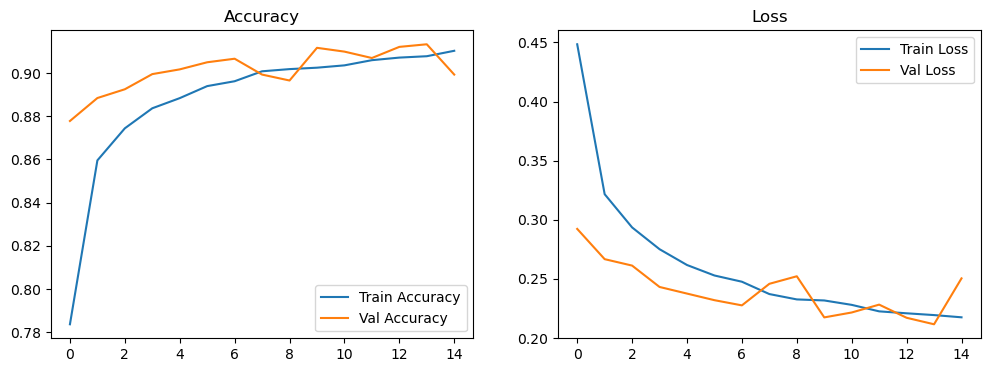

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()


## 11. Real-Time Inference

The trained model is deployed in a real-time webcam application.

Pipeline:
1. Face detection using Haar cascades
2. Face cropping and preprocessing
3. CNN prediction
4. Confidence estimation

This demonstrates the **practical usability** of the trained model.


In [28]:
from tensorflow.keras.models import load_model

model = load_model("smile_cnn_finetuned.keras")


In [33]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

model = load_model("baseline_smile_cnn.h5")

# Face detector
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

def preprocess_face(face_bgr):
    face_rgb = cv2.cvtColor(face_bgr, cv2.COLOR_BGR2RGB)
    face_rgb = cv2.resize(face_rgb, (64, 64))
    face_rgb = face_rgb / 255.0
    face_rgb = np.expand_dims(face_rgb, axis=0)
    return face_rgb

cap = cv2.VideoCapture(0)

print("SPACE: capture 1 frame and predict | Q: quit")
last_text = "Press SPACE to predict"

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect face on the live frame (works on grayscale)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5)

    # Draw rectangles so you see what it detected
    for (x,y,w,h) in faces[:1]:
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2)

    cv2.putText(frame, last_text, (20,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    cv2.imshow("Smile Detection (face-crop)", frame)

    key = cv2.waitKey(1) & 0xFF

    if key == 32:  # SPACE
        if len(faces) == 0:
            last_text = "No face detected"
            print(last_text)
        else:
            # Use the first detected face
            x,y,w,h = faces[0]
            face = frame[y:y+h, x:x+w]

            inp = preprocess_face(face)
            pred = float(model.predict(inp)[0][0])

            label = "Smiling 🙂" if pred >= 0.5 else "Not Smiling 😐"
            conf = abs(pred - 0.5) * 2  # 0..1 confidence

            last_text = f"{label} ({pred:.2f})"
            print(f"Prediction: {label} | score={pred:.2f} | conf={conf*100:.1f}%")

    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


SPACE: capture 1 frame and predict | Q: quit
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Prediction: Not Smiling 😐 | score=0.07 | conf=85.3%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction: Not Smiling 😐 | score=0.11 | conf=78.2%
No face detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction: Not Smiling 😐 | score=0.12 | conf=76.9%
No face detected
No face detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction: Not Smiling 😐 | score=0.22 | conf=55.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction: Not Smiling 😐 | score=0.29 | conf=41.1%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction: Not Smiling 😐 | score=0.13 | conf=73.2%


In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # shape (1, 64, 64, 3)
    return img


In [35]:
image_path = "please.jpg"  # put your image here

img = preprocess_image(image_path)
prediction = model.predict(img)[0][0]

label = "Smiling 🙂" if prediction > 0.5 else "Not Smiling 😐"

print("Prediction score:", prediction)
print("Result:", label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction score: 0.2776591
Result: Not Smiling 😐


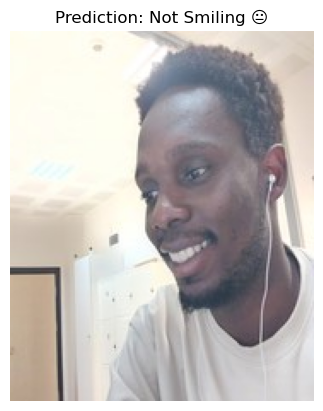

In [36]:
img_display = cv2.imread(image_path)
img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)

plt.imshow(img_display)
plt.axis("off")
plt.title(f"Prediction: {label}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


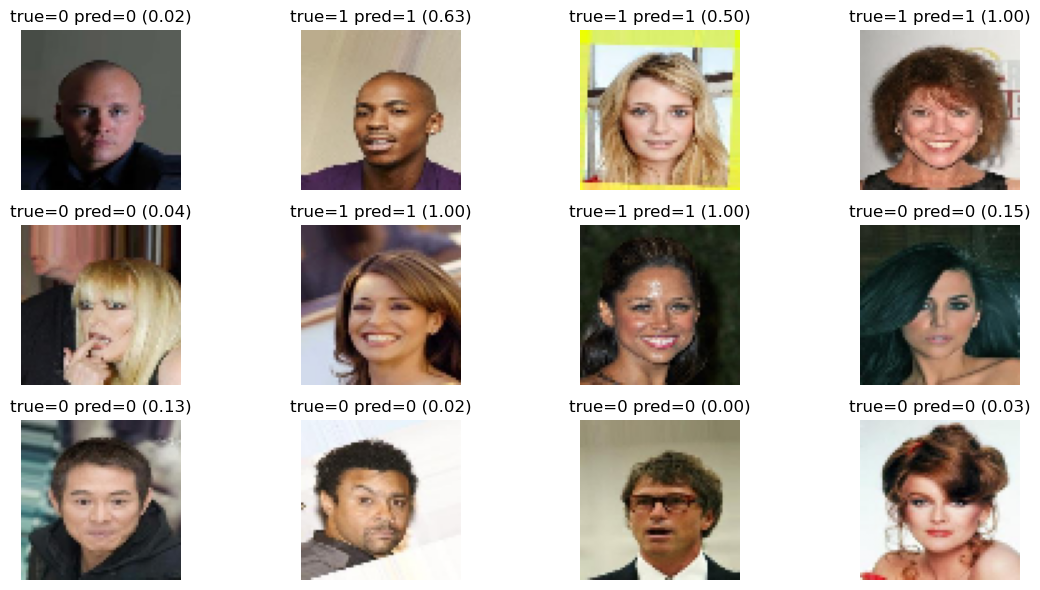

In [37]:
import matplotlib.pyplot as plt
import numpy as np

idxs = np.random.choice(len(X_test), size=12, replace=False)

preds = model.predict(X_test[idxs]).reshape(-1)
pred_labels = (preds > 0.5).astype(int)

plt.figure(figsize=(12,6))
for i, idx in enumerate(idxs):
    plt.subplot(3,4,i+1)
    plt.imshow(X_test[idx])
    plt.axis("off")
    plt.title(f"true={y_test[idx]} pred={pred_labels[i]} ({preds[i]:.2f})")
plt.tight_layout()
plt.show()


## 12. Motivation for Fine-Tuning

To simulate real-world domain adaptation, the model is fine-tuned on a smaller external dataset
("Smiling or Not Face Data").

Motivation:
- Adapt the model to a new data distribution
- Improve performance on a specific target domain
- Study the effects of fine-tuning on generalization and bias


## 13. Fine-Tuning Dataset

The fine-tuning dataset consists of:
- Two classes: smile / non_smile
- ~1,200 images
- Balanced class distribution

Images are resized and normalized to match the baseline training pipeline.


In [38]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

IMG_SIZE = 64

def load_smile_dataset(base_dir):
    X, y = [], []

    class_map = {
        "non_smile": 0,
        "smile": 1
    }

    for class_name, label in class_map.items():
        folder = os.path.join(base_dir, class_name)
        for fname in os.listdir(folder):
            img_path = os.path.join(folder, fname)
            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0

            X.append(img)
            y.append(label)

    return np.array(X, dtype=np.float32), np.array(y)

X_ft, y_ft = load_smile_dataset("smile_data")

print("Fine-tune dataset:", X_ft.shape, y_ft.shape)
print("Smiling:", np.sum(y_ft == 1), "| Not smiling:", np.sum(y_ft == 0))


Fine-tune dataset: (1203, 64, 64, 3) (1203,)
Smiling: 600 | Not smiling: 603


In [39]:
X_ft_train, X_ft_val, y_ft_train, y_ft_val = train_test_split(
    X_ft, y_ft,
    test_size=0.2,
    random_state=42,
    stratify=y_ft
)

print("Train:", X_ft_train.shape)
print("Val:", X_ft_val.shape)


Train: (962, 64, 64, 3)
Val: (241, 64, 64, 3)


## 14. Fine-Tuning Strategy

Fine-tuning is performed in two stages:

Stage 1:
- Freeze all layers except the final classification layer
- Allows adaptation of decision boundary only

Stage 2:
- Unfreeze the last dense layers
- Allows limited feature adaptation

A low learning rate is used to avoid drastic weight updates.


In [40]:
for layer in model.layers[:-1]:
    layer.trainable = False

model.layers[-1].trainable = True


In [41]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)


0 conv2d_2 False
1 max_pooling2d_2 False
2 conv2d_3 False
3 max_pooling2d_3 False
4 flatten_1 False
5 dense_2 False
6 dense_3 True


In [42]:
import tensorflow as tf

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [43]:
history_ft = model.fit(
    X_ft_train, y_ft_train,
    validation_data=(X_ft_val, y_ft_val),
    epochs=6,
    batch_size=16,
    shuffle=True
)


Epoch 1/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5291 - loss: 1.3760 - val_accuracy: 0.5104 - val_loss: 1.4349
Epoch 2/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5343 - loss: 1.3325 - val_accuracy: 0.5270 - val_loss: 1.3950
Epoch 3/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5364 - loss: 1.2936 - val_accuracy: 0.5187 - val_loss: 1.3576
Epoch 4/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5416 - loss: 1.2563 - val_accuracy: 0.5187 - val_loss: 1.3224
Epoch 5/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5364 - loss: 1.2215 - val_accuracy: 0.5187 - val_loss: 1.2901
Epoch 6/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5385 - loss: 1.1897 - val_accuracy: 0.5228 - val_loss: 1.2596


In [44]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)


0 conv2d_2 False
1 max_pooling2d_2 False
2 conv2d_3 False
3 max_pooling2d_3 False
4 flatten_1 False
5 dense_2 False
6 dense_3 True


In [45]:
for layer in model.layers[:-2]:
    layer.trainable = False

for layer in model.layers[-2:]:
    layer.trainable = True


In [46]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)


0 conv2d_2 False
1 max_pooling2d_2 False
2 conv2d_3 False
3 max_pooling2d_3 False
4 flatten_1 False
5 dense_2 True
6 dense_3 True


In [47]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [48]:
history_ft = model.fit(
    X_ft_train, y_ft_train,
    validation_data=(X_ft_val, y_ft_val),
    epochs=10,
    batch_size=16,
    shuffle=True
)


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8410 - loss: 0.4018 - val_accuracy: 0.9087 - val_loss: 0.2330
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9543 - loss: 0.1369 - val_accuracy: 0.9253 - val_loss: 0.2119
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9605 - loss: 0.1123 - val_accuracy: 0.9129 - val_loss: 0.2220
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9823 - loss: 0.0683 - val_accuracy: 0.9336 - val_loss: 0.1576
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9886 - loss: 0.0469 - val_accuracy: 0.9419 - val_loss: 0.1469
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9927 - loss: 0.0339 - val_accuracy: 0.9419 - val_loss: 0.1459
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9969 - loss: 0.0269 - val_accuracy: 0.9585 - val_loss: 0.1257
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9990 - loss: 0.0206 - val_accuracy: 0.9668 - v

In [49]:
model.save("smile_cnn_finetuned.keras")


In [50]:
val_loss, val_acc = model.evaluate(X_ft_val, y_ft_val)
print("Fine-tune Val Accuracy:", val_acc)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9627 - loss: 0.1152
Fine-tune Val Accuracy: 0.9626556038856506


In [51]:
from tensorflow.keras.models import load_model
model = load_model("smile_cnn_finetuned.keras")


## 15. Fine-Tuning Training Results

After fine-tuning:
- Validation accuracy improves significantly on the new dataset
- The model adapts well to the new domain

However, this improvement is **domain-specific**.


In [52]:
from tensorflow.keras.models import load_model

model_ft = load_model("smile_cnn_finetuned.keras")


In [53]:
y_pred_prob_ft = model_ft.predict(X_test)
y_pred_ft = (y_pred_prob_ft > 0.5).astype(int).flatten()


285/285 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


In [54]:
test_eval_ft = test_data.copy().reset_index(drop=True)
test_eval_ft["y_true"] = y_test
test_eval_ft["y_pred"] = y_pred_ft


## 16. Post Fine-Tuning Bias Evaluation

The fine-tuned model is re-evaluated on the original CelebA test set.

Findings:
- Significant drop in overall accuracy
- Performance decreases across all demographic groups


In [55]:
def group_accuracy(df):
    return (df["y_true"] == df["y_pred"]).mean()


In [56]:
male_data_ft = test_eval_ft[test_eval_ft["Male"] == 1]
female_data_ft = test_eval_ft[test_eval_ft["Male"] == -1]

male_acc_ft = group_accuracy(male_data_ft)
female_acc_ft = group_accuracy(female_data_ft)

print("Fine-tuned Accuracy (Male):", male_acc_ft)
print("Fine-tuned Accuracy (Female):", female_acc_ft)
print("Gender Accuracy Gap (FT):", abs(male_acc_ft - female_acc_ft))


Fine-tuned Accuracy (Male): 0.6206806282722513
Fine-tuned Accuracy (Female): 0.6709458183877667
Gender Accuracy Gap (FT): 0.050265190115515335


In [57]:
pale_data_ft = test_eval_ft[test_eval_ft["Pale_Skin"] == 1]
non_pale_data_ft = test_eval_ft[test_eval_ft["Pale_Skin"] == -1]

pale_acc_ft = group_accuracy(pale_data_ft)
non_pale_acc_ft = group_accuracy(non_pale_data_ft)

print("Fine-tuned Accuracy (Pale):", pale_acc_ft)
print("Fine-tuned Accuracy (Non-pale):", non_pale_acc_ft)
print("Skin Tone Accuracy Gap (FT):", abs(pale_acc_ft - non_pale_acc_ft))


Fine-tuned Accuracy (Pale): 0.5372340425531915
Fine-tuned Accuracy (Non-pale): 0.6547305800251687
Skin Tone Accuracy Gap (FT): 0.11749653747197719


## 17. Bias Comparison: Before vs After Fine-Tuning

A direct comparison of group accuracies shows:

- Accuracy degradation after fine-tuning
- Similar performance drops across all groups

This indicates **catastrophic forgetting**, rather than increased demographic bias.


In [58]:
bias_comparison = pd.DataFrame({
    "Group": ["Male", "Female", "Pale", "Non-pale"],
    "Before_FT": [
        male_acc,
        female_acc,
        pale_acc,
        non_pale_acc
    ],
    "After_FT": [
        male_acc_ft,
        female_acc_ft,
        pale_acc_ft,
        non_pale_acc_ft
    ]
})

bias_comparison["Gap_Change"] = bias_comparison["After_FT"] - bias_comparison["Before_FT"]

print(bias_comparison)


      Group  Before_FT  After_FT  Gap_Change
0      Male   0.896335  0.620681   -0.275654
1    Female   0.913158  0.670946   -0.242213
2      Pale   0.925532  0.537234   -0.388298
3  Non-pale   0.905274  0.654731   -0.250543


In [59]:
print("Mean prediction:", np.mean(y_pred_ft))
print("Std prediction:", np.std(y_pred_ft))


Mean prediction: 0.7242513984863442
Std prediction: 0.4468907140195675


## 18. Discussion: Catastrophic Forgetting

Fine-tuning on a small, domain-specific dataset caused the model to:
- Overfit to the new domain
- Lose generalizable features learned from CelebA

This phenomenon is known as **catastrophic forgetting** and represents a key limitation of naive fine-tuning.


## 19. Ethical and Responsible AI Considerations

This experiment highlights important ethical lessons:
- Accuracy improvements can hide generalization failures
- Bias should be evaluated before and after model adaptation
- Responsible AI requires transparency about trade-offs

Negative results are as important as positive ones.
